In [3]:
import pandas as pd
import numpy as np
import os
import h5py
import requests
import json
import time

from IPython.display import Image
from IPython.display import display
from IPython.display import HTML

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as kimage

from utils import get_movies_and_links_merged, \
    save_predictions_matrix, log_time_left, has_corresponding_image
    
import matplotlib.pyplot as plt



Using TensorFlow backend.


In [4]:
movies_and_links = get_movies_and_links_merged()
linkIds = map(str, filter(has_corresponding_image, movies_and_links.imdbId.unique()))

imdbIdToTitle = {'tt' + row.imdbId: row.title for row in movies_and_links.itertuples() if row.imdbId in linkIds}
movies_and_links.head()
len(linkIds), len(imdbIdToTitle)

Getting data from /Users/patrykkowalczyk/Desktop/ml-latest-small/movies.csv
Getting data from /Users/patrykkowalczyk/Desktop/ml-latest-small/links.csv


(9121, 9121)

In [5]:
from utils import get_all_data
ratings, links, movies = get_all_data()

ratings_and_links = pd.merge(ratings, links, on='movieId', how='left')
all_data = pd.merge(ratings_and_links, movies, on='movieId', how='left')
all_data = all_data.loc[all_data['imdbId'].notnull()]


all_data['movieId'] = ratings_and_links['imdbId']
all_data.userId = ratings_and_links.userId.astype('category').cat.codes.values
all_data.movieId = ratings_and_links.movieId.astype('category').cat.codes.values


# linkIds_2 = map(str, filter(lambda x: not has_corresponding_image(x), all_data.imdbId.unique()))
len(all_data.imdbId.unique())

Getting data from /Users/patrykkowalczyk/Desktop/ml-latest-small/ratings.csv
Getting data from /Users/patrykkowalczyk/Desktop/ml-latest-small/links.csv
Getting data from /Users/patrykkowalczyk/Desktop/ml-latest-small/movies.csv


9066

In [6]:
img_files = map(lambda x: x[:-4], os.listdir('img'))
total_movies = len(img_files)
total_movies

9121

In [7]:
len(ratings.userId.unique())

671

In [9]:
ratings.shape

(100004, 4)

In [10]:
sparsity = float(ratings.notnull().shape[0])
sparsity /= len(ratings.userId.unique()) * len(ratings.movieId.unique())
sparsity *= 100
sparsity

1.6439141608663475

In [11]:
set(links.imdbId.unique()) - set(linkIds)

{'0108227', '0116992', '0422258', '3611354'}

In [12]:
no_image_movies = {'0108227', '0116992', '0422258', '3611354'}

In [13]:
unrated_movies = (set(links.movieId.unique()) - set(ratings.movieId.unique()))

In [14]:
unrated_movies = set(links.loc[links['movieId'].isin(unrated_movies)].imdbId.unique())

In [15]:
filter(lambda m: m in no_image_movies, unrated_movies)

[]

In [16]:
len(no_image_movies.union(unrated_movies))

63

In [17]:
all_data.loc[ratings_and_links['imdbId'].isin(no_image_movies)]

userId  movieId rating   timestamp   imdbId  tmdbId  \
13466     656     8177    3.0   848161552  0108227  297645   
66947     409     8128    3.5  1296196412  0422258   90272   
67356     414     7688    3.0   939691164  0116992     NaN   
69909     424     1028    4.5  1437004716  3611354  284362   

                                                   title       genres  
13466  Story of Xinghua, The (Xinghua san yue tian) (...        Drama  
66947             Fern flowers (Fleur de fougère) (1949)    Animation  
67356          Marlene Dietrich: Shadow and Light (1996)  Documentary  
69909                     El vals de los inútiles (2014)  Documentary

In [18]:
movies_and_links.shape[0] - len(all_data.imdbId.unique())
unrated_movies = set(movies_and_links.imdbId.unique()) - set(all_data.imdbId.unique())


In [19]:
uid_to_m_count = {}
mid_to_u_count = {}


i = 0
for index, row in all_data[['userId', 'movieId']].iterrows():
    if row[0] in uid_to_m_count:
        uid_to_m_count[row[0]] += 1
    else:
        uid_to_m_count[row[0]] = 1
        
    if row[1] in mid_to_u_count:
        mid_to_u_count[row[1]] += 1
    else:
        mid_to_u_count[row[1]] = 1
        
for m in unrated_movies:
    mid_to_u_count[m] = 0

In [20]:
print 'Max no. of movies rated by a user: %d' % max(uid_to_m_count.values())
print 'Max no. of users who rated a movie: %d' % max(mid_to_u_count.values())

print 'Min no. of movies rated by a user: %d' % min(uid_to_m_count.values())
print 'Min no. of users who rated a movie: %d' % min(mid_to_u_count.values())

Max no. of movies rated by a user: 2391
Max no. of users who rated a movie: 341
Min no. of movies rated by a user: 20
Min no. of users who rated a movie: 0


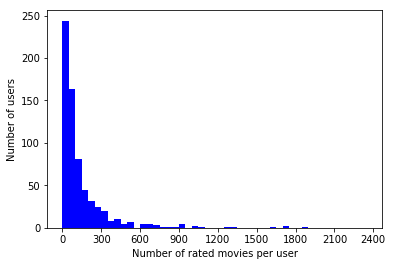

In [297]:
plt.xticks(xrange(0, 2700, 300))
plt.xlabel('Number of rated movies per user')
plt.ylabel('Number of users')

# plt.hist(uid_to_m_count.values(), bins=[i for i in xrange(0, 2400, 50)], color='orange', log=True)
# plt.savefig('/Users/patrykkowalczyk/Projects/studies/master-thesis/Master thesis/images/rating_users_hist_log.png')

plt.hist(uid_to_m_count.values(), bins=[i for i in xrange(0, 2400, 50)], color='b')
plt.savefig('/Users/patrykkowalczyk/Projects/studies/master-thesis/Master thesis/images/rating_users_hist.png')

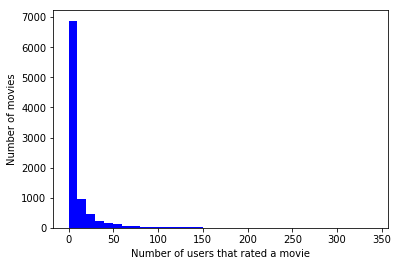

In [296]:
# plt.xticks(xrange(0, 2400, 300))

plt.xticks(xrange(0, 375, 50))
plt.xlabel('Number of users that rated a movie')
plt.ylabel('Number of movies')

# plt.hist(mid_to_u_count.values(), bins=[i for i in xrange(0, 350, 10)], color='orange', log=True)
# plt.savefig('/Users/patrykkowalczyk/Projects/studies/master-thesis/Master thesis/images/rated_movies_hist_log.png')

plt.hist(mid_to_u_count.values(), bins=[i for i in xrange(0, 350, 10)], color='b')
plt.savefig('/Users/patrykkowalczyk/Projects/studies/master-thesis/Master thesis/images/rated_movies_hist.png')

In [21]:
print np.percentile(uid_to_m_count.values(), q=[0, 5, 25, 50, 75, 90, 95, 100])
k=uid_to_m_count.values()
len(filter(lambda x: x<10, k)) / float(len(k))

[   20.    21.    37.    71.   161.   323.   520.  2391.]


0.0

In [22]:
print np.percentile(mid_to_u_count.values(), q=[0, 5, 25, 50, 75, 90, 95, 100])

k=mid_to_u_count.values()

len(filter(lambda x: x<29, k)) / float(len(k))

[   0.    1.    1.    3.    9.   28.   49.  341.]


0.9032328767123288

In [24]:
# movies_and_links.head()
x = pd.merge(movies_and_links[['movieId', 'imdbId', 'title', 'genres']], all_data[['movieId', 'imdbId']], on='imdbId', how='left').drop_duplicates()

m_id_to_genres = {r[0]: set(r[1].split('|')) for _, r in x[['imdbId', 'genres']].iterrows()}

In [25]:
m_id_to_genres

{'0113972': {'Action', 'Thriller'},
 '0113973': {'Documentary'},
 '0803096': {'Action', 'Adventure', 'Fantasy'},
 '2370248': {'Drama'},
 '0107086': {'Documentary'},
 '0439289': {'Comedy', 'Drama'},
 '1220634': {'Action', 'Horror', 'IMAX', 'Sci-Fi', 'Thriller'},
 '0439533': {'Action', 'Adventure', 'Animation', 'Comedy', 'Sci-Fi'},
 '1850457': {'Children', 'Comedy'},
 '0317198': {'Comedy', 'Drama', 'Romance'},
 '0457572': {'Comedy', 'Horror', 'Thriller'},
 '0338564': {'Crime', 'Drama', 'Thriller'},
 '0417385': {'Drama'},
 '0179098': {'Drama', 'Romance'},
 '0037558': {'Drama', 'Romance'},
 '0929629': {'Sci-Fi'},
 '0111399': {'Comedy'},
 '1571222': {'Drama', 'Thriller'},
 '3128900': {'Drama'},
 '0089092': {'Adventure', 'Drama', 'Sci-Fi'},
 '2310332': {'Adventure', 'Fantasy'},
 '0044502': {'Drama', 'Film-Noir'},
 '0090098': {'Comedy'},
 '0090768': {'Drama', 'Fantasy'},
 '0107665': {'Drama', 'Horror'},
 '1645170': {'Comedy'},
 '0112883': {'Comedy', 'Drama', 'Romance'},
 '0112887': {'Comedy',

In [26]:
all_genres = set()
for genres in m_id_to_genres.values():
    all_genres.update(genres)
# {'D', 'A'}.union({'A', 'B'})

In [27]:
all_genres

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [58]:
genres_to_m_count = { g: 0 for g in all_genres} 
for genres in m_id_to_genres.values():
    for g in genres:
        if g in genres_to_m_count:
            genres_to_m_count[g] += 1
        else:
            genres_to_m_count[g] = 1
            
genres_to_m_count['Undefined'] = genres_to_m_count['(no genres listed)']
genres_to_m_count.pop('(no genres listed)', None)

18

In [131]:
genres_to_m_count

{'Action': 1545,
 'Adventure': 1117,
 'Animation': 447,
 'Children': 583,
 'Comedy': 3315,
 'Crime': 1100,
 'Documentary': 495,
 'Drama': 4365,
 'Fantasy': 654,
 'Film-Noir': 133,
 'Horror': 877,
 'IMAX': 153,
 'Musical': 394,
 'Mystery': 543,
 'Romance': 1545,
 'Sci-Fi': 792,
 'Thriller': 1729,
 'Undefined': 18,
 'War': 367,
 'Western': 168}

In [60]:
import matplotlib.pyplot as plt


# plt.xticks(xrange(0, 375, 50))

genres_counts = map(lambda x: len(x), m_id_to_genres.values())
set(genres_counts)

{1, 2, 3, 4, 5, 6, 7, 8, 10}

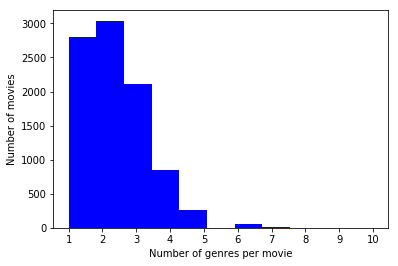

In [50]:
plt.xticks(xrange(11))
plt.xlabel('Number of genres per movie')
plt.ylabel('Number of movies')
plt.hist(genres_counts, color='blue', bins=11)
# plt.show()
plt.savefig('/Users/patrykkowalczyk/Projects/studies/master-thesis/Master thesis/images/genres_dist.png')

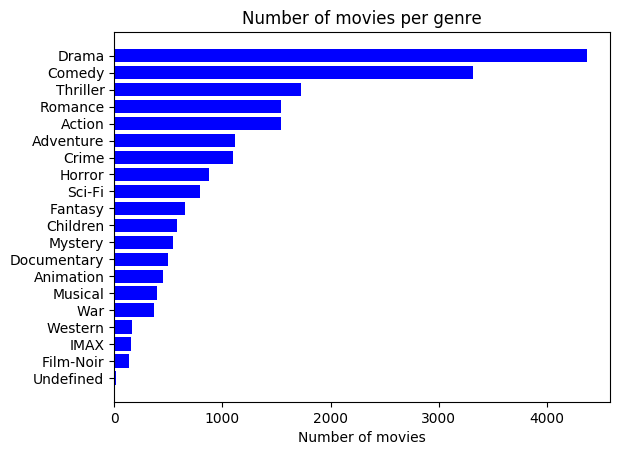

In [149]:
labels = sorted(genres_to_m_count.keys(), key=lambda x: genres_to_m_count[x], reverse=True)
sizes = map(lambda x: genres_to_m_count[x], labels)

# plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(labels))
m_counts = map(lambda x: genres_to_m_count[x], labels)

ax.barh(y_pos, sizes, align='center',
        color='blue', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of movies')
ax.set_title('Number of movies per genre')

# plt.show()
plt.savefig('/Users/patrykkowalczyk/Projects/studies/master-thesis/Master thesis/images/movies_per_genre.png')

In [124]:
genres_sorted = sorted(genres_to_m_count.keys(), key=lambda x: x if x != 'Undefined' else 'ZZZZ', reverse=True)

In [152]:
genres_to_m_count

{'Action': 1545,
 'Adventure': 1117,
 'Animation': 447,
 'Children': 583,
 'Comedy': 3315,
 'Crime': 1100,
 'Documentary': 495,
 'Drama': 4365,
 'Fantasy': 654,
 'Film-Noir': 133,
 'Horror': 877,
 'IMAX': 153,
 'Musical': 394,
 'Mystery': 543,
 'Romance': 1545,
 'Sci-Fi': 792,
 'Thriller': 1729,
 'Undefined': 18,
 'War': 367,
 'Western': 168}

In [161]:
len(filter(lambda x: x <=3, map(lambda x: len(x), m_id_to_genres.values()))) / 9125.0


0.8709041095890411

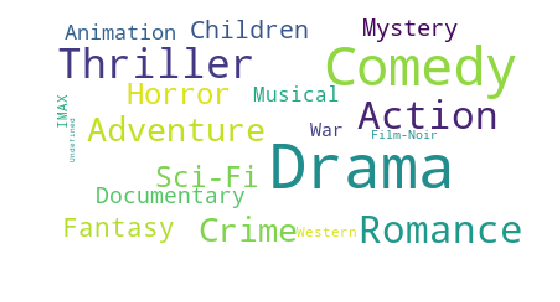

In [177]:
import matplotlib as mpl

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


stopwords = set(STOPWORDS)
g = list(genres_to_m_count.keys())
counts = [genres_to_m_count[q] for q in g]
data = pd.DataFrame.from_dict({'genre':g, 'movies_count':counts})



wordcloud = WordCloud(
                          background_color='white',
                          max_words=30,
                          max_font_size=50, 
                          random_state=142
                         ).fit_words(genres_to_m_count)
# .fit_words([(k, v) for k, v in genres_to_m_count.iteritems()])
# .generate(str(data['genre']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
# plt.show()
plt.savefig('/Users/patrykkowalczyk/Projects/studies/master-thesis/Master thesis/images/genre_wordcloud.png')

In [181]:
p = sorted(genres_to_m_count.values(), reverse=True)
[sum(p[:i]) for i in xrange(1, len(p))]

[4365,
 7680,
 9409,
 10954,
 12499,
 13616,
 14716,
 15593,
 16385,
 17039,
 17622,
 18165,
 18660,
 19107,
 19501,
 19868,
 20036,
 20189,
 20322]

In [183]:
for u, m in uid_to_m_count.iteritems():
    if m > 1500:
        print u

56
497
516
583
642
